In [288]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *
from numpy import *
import numpy as np

In [289]:
"""flu"""
tc_flu = 5      # time between contacts in days 
tr_flu = 14      # recovery time in days

beta_flu = 1 / tc_flu      # contact rate in per day
gamma_flu = 1 / tr_flu     # recovery rate in per day
days = 2

In [290]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=99, I=1, R=0)
    init /= np.sum(init)
    
    
    t0 = 0
    t_end = 7*32 # 224days 

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)


In [291]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i, r = state

    infected = beta * i * s
    recovered = gamma * i
    
    s -= infected 
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [292]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame

In [293]:
def add_quarantine(system, fraction):
    high = 5
    tc_flu = fraction * high + high 
    system.beta = 1 /tc_flu

In [294]:
def add_medicine(system, days):
    system.gamma = 1/ (tr_flu - days)

In [295]:
flu_q = make_system(beta_flu, gamma_flu)
add_quarantine(flu_q, 0.3)
run_simulation(flu_q, update1)

In [296]:
def plot_results(S, I, R, title):
    plot(S, '--', color='blue', label = 'Susceptible')
    plot(I, '-', color='red', label = 'Infected')
    plot(R, ':', color='green', label = 'Resistant')
    decorate(xlabel='Time (days)',
         ylabel='Fraction of population', title=title)

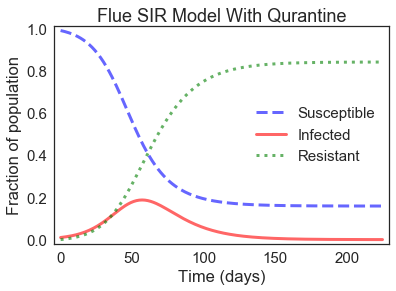

In [297]:
newfig()
plot_results(flu_q.results.S, flu_q.results.I, flu_q.results.R, title = 'Flue SIR Model With Qurantine')

In [298]:
flu_qurantine = abs(flu_q.results.S.diff().values) #calculate the difference in fraction of susceptible people between each day

In [299]:
slope_flu_q = flu_qurantine[1:] #eliminate the first NAN value

In [300]:
check_slope_flu_q = less(slope_flu_q, 1e-03) #check whether the differences are smaller than 1e-03

In [301]:
day = argmax(check_slope_flu_q) + 2 #give the index of the first difference that is smaller than 1e-03
#plus two days to get the actual day number
print ("day=", day)

day= 113


In [302]:
def equilibrium_day(SIR):
    """wrap all the functions above in one function,
    SIR is the serie that we need to find the equilibrium day for"""
    difference = abs(SIR.diff().values)
    slope = difference[1:]
   # print(slope)
    check_slope = less(slope, 1e-03)
    day = argmax(check_slope) +2
    print ("day=", day)
    return day

In [303]:
equilibrium_day(flu_q.results.S)

day= 113


113

In [304]:
def equilibrium_day_gradient(SIR):
    """wrap all the functions above in one function,
    SIR is the serie that we need to find the equilibrium day for using the gradient method"""
    slope = abs(np.gradient(SIR))
    # print(slope)
    day = argmax(less(slope, 1e-03)) +2
    print ("day=", day)
    return day

In [305]:
equilibrium_day_gradient(flu_q.results.S)

day= 113


113

In [317]:
flu_m = make_system(beta_flu, gamma_flu)
add_medicine(flu_m, 2)
run_simulation(flu_m, update1)

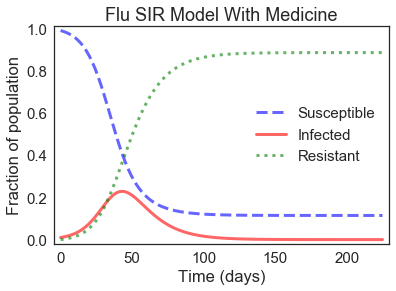

In [318]:
newfig()
plot_results(flu_m.results.S, flu_m.results.I, flu_m.results.R, title="Flu SIR Model With Medicine")

In [319]:
equilibrium_day_gradient(flu_m.results.S)

day= 89


89

In [320]:
equilibrium_day(flu_m.results.S)

day= 88


88

In [321]:
def plot_comparison(S_m, S_q, title):
    plot(S_m, '-', color='blue', label = 'Medicine')
    plot(S_q, '-', color='red', label = 'Quarantine')
    decorate(xlabel='Time (days)',
         ylabel='Fraction of population', title=title)

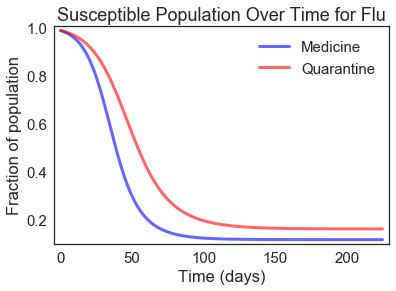

In [322]:
newfig()
plot_comparison(flu_m.results.S, flu_q.results.S, title = "Susceptible Population Over Time for Flu")

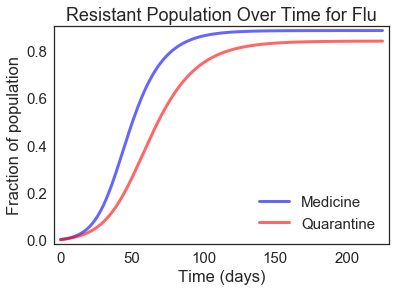

In [323]:
newfig()
plot_comparison(flu_m.results.R, flu_q.results.R, title = "Resistant Population Over Time for Flu")

In [313]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [249]:
def calculate_total_cost(system, cost_per_day, num_days):
    total_infected = calc_total_infected(system = system)
    cost = total_infected * 100 * cost_per_day * num_days
    return cost

In [329]:
flu_medicine = calculate_total_cost(flu_m, 20, 5)
print("cost of flu medicine treatment=", flu_medicine)

cost of flu medicine treatment= 8756.67722191


In [331]:
flu_quarantine = calculate_total_cost(flu_q, 50, 113)
print("cost of flu quarantine treatment=", flu_quarantine)

cost of flu quarantine treatment= 469507.833948
